In [48]:

import xgboost as xgb
import optuna
import pandas as pd
import numpy as np
from google.cloud import bigquery
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from etrace.load_data import load_from_bq
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [49]:
df = load_from_bq("SELECT * FROM aklewagonproject.etrace.cleaned_final_jaume_dataset")

In [50]:
df.head()

,geo,year,pop,employment_rate,gdp_capita,NUTS_NAME,area_km2,pop_dens,pct_Dfb,pct_Dfc,...,tg,tn,rr,hu,fg,qq,NUTS_NAME_completo,CNTR_CODE,is_coastal,nights_spent
0,CY00,2000,690497.0,72.0,15600.0,Κύπρος,9258.638861,74.578673,0.0,0.0,...,17.780682,12.977951,1529.9,64.00403,NaN,211.34894,Κύπρος,CY,1,17419055.0
1,CY00,2001,697549.0,74.1,16500.0,Κύπρος,9258.638861,75.340340,0.0,0.0,...,18.387470,13.226036,1278.5,66.11222,NaN,211.04190,Κύπρος,CY,1,18826208.0
2,CY00,2002,705539.0,75.1,17000.0,Κύπρος,9258.638861,76.203318,0.0,0.0,...,18.006903,13.176366,1139.8,64.16601,2.477030,210.07408,Κύπρος,CY,1,16159347.0
3,CY00,2003,713720.0,75.4,17900.0,Κύπρος,9258.638861,77.086925,0.0,0.0,...,17.819433,13.130839,1551.3,65.35384,2.512868,210.00092,Κύπρος,CY,1,14457937.0
4,CY00,2004,722893.0,75.7,19100.0,Κύπρος,9258.638861,78.077675,0.0,0.0,...,17.856602,12.773023,1396.0,63.41954,2.470100,211.56319,Κύπρος,CY,1,14717269.0


## Some of the NUTS-2 IDs are missing a lot of years to solve this we will apply a filter, first of all lets see which are this IDs

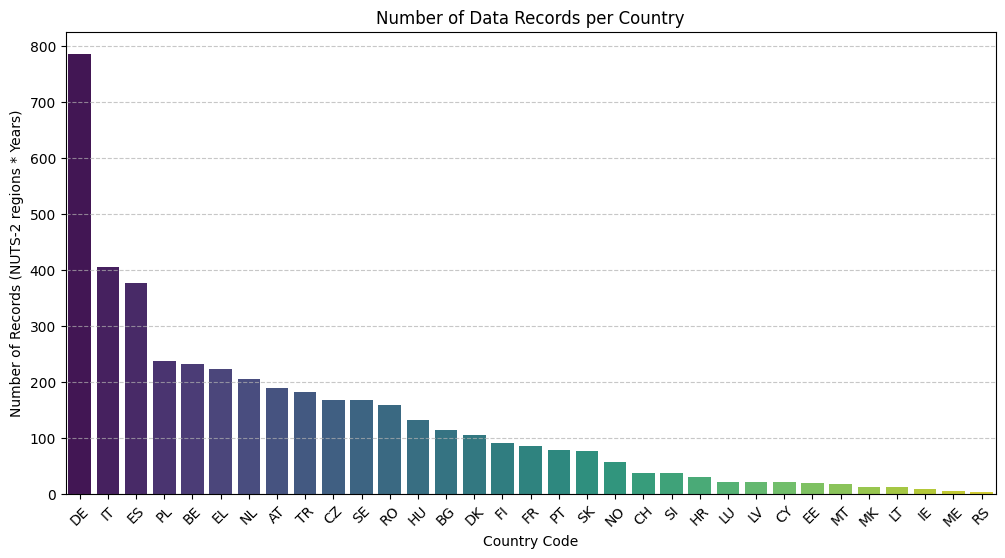

In [51]:
# Extract Country Code from the 'geo' column (NUTS-2 IDs)
df['country'] = df['geo'].str[:2]

country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['country', 'record_count']

# Uncomment the follow two lines if you want to see a table with lowest country records
# print("Countries with the fewest records:")
# print(country_counts.sort_values('record_count').head(10))

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=country_counts, x='country', y='record_count', hue='country', palette='viridis', legend=False)
plt.title('Number of Data Records per Country')
plt.xlabel('Country Code')
plt.ylabel('Number of Records (NUTS-2 regions * Years)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [52]:
# List of countries to exclude based on low record count analysis
countries_to_drop = ['RS', 'ME', 'IE', 'LT', 'MK', 'MT', 'EE', 'LU', 'LV', 'CY']

# Filter the DataFrame
df_clean = df[~df['country'].isin(countries_to_drop)].copy()

df_clean = df_clean.drop(columns=['CNTR_CODE','NUTS_NAME_completo','NUTS_NAME'])

print(f"Original shape: {df.shape}")
print(f"Shape after dropping low-data countries: {df_clean.shape}")

Original shape: (4317, 43)
Shape after dropping low-data countries: (4175, 40)


In [53]:
df_clean.head()

,geo,year,pop,employment_rate,gdp_capita,area_km2,pop_dens,pct_Dfb,pct_Dfc,pct_ET,...,tx,tg,tn,rr,hu,fg,qq,is_coastal,nights_spent,country
80,TR21,2013,1593247.0,59.1,10600.0,18793.144498,84.778096,0.000143,0.0,0.0,...,19.945833,15.458276,9.657729,377.70000,69.656900,3.233678,182.59195,1,435859.0,TR
81,TR21,2014,1613616.0,60.1,10500.0,18793.144498,85.861948,0.000157,0.0,0.0,...,20.907137,16.468649,10.751060,699.00000,68.810936,2.919067,154.01929,1,545903.0,TR
82,TR21,2015,1650735.0,61.6,11300.0,18793.144498,87.837083,0.000170,0.0,0.0,...,21.401037,17.219908,10.335670,350.80002,66.983536,3.215793,170.11890,1,588416.0,TR
83,TR21,2016,1687420.0,62.6,11400.0,18793.144498,89.789125,0.000181,0.0,0.0,...,21.548605,17.030355,10.000297,342.70000,68.493770,3.064006,160.80713,1,586368.0,TR
84,TR32,2013,2808243.0,61.0,8200.0,32506.717238,86.389622,0.000000,0.0,0.0,...,14.165085,8.875000,3.571441,431.50000,73.402120,2.110297,194.54237,1,17870115.0,TR


In [54]:
df_clean['pop_dens'].isna().sum()

np.int64(72)

In [55]:
cols_to_exclude = ["nights_spent", "geo", "year","country"]

X = df_clean.drop(
    columns=[c for c in cols_to_exclude if c in df_clean.columns], errors="ignore"
)
y = df_clean["nights_spent"]

N_FOLDS = 5

cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_predictions = np.zeros(len(X)) #Out of fold
fold_scores = []

# Model parameters
model_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "learning_rate": 0.1,
    "max_depth": 11,
    "min_child_weight": 16,
    "subsample": 0.77,
    "colsample_bytree": 0.96,
    "lambda": 0.07,
    "alpha": 8.48,
    "random_state": 42,
    "verbosity": 0,
}

for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
    # Split data
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]

    #We need DMatrix because XGB doesnt work with pd dataframes :(
    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval = xgb.DMatrix(X_val_fold, label=y_val_fold)

    model = xgb.train(
        params=model_params,
        dtrain=dtrain,
        num_boost_round=200,
        evals=[(dval, "validation")],
        early_stopping_rounds=20,
        verbose_eval=False,
    )

    fold_predictions = model.predict(dval)
    oof_predictions[val_idx] = fold_predictions

    # Calculate fold metrics
    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, fold_predictions))
    fold_r2 = r2_score(y_val_fold, fold_predictions)
    fold_scores.append({"fold": fold + 1, "rmse": fold_rmse, "r2": fold_r2})


overall_rmse = np.sqrt(mean_squared_error(y, oof_predictions))
overall_r2 = r2_score(y, oof_predictions)


fold_rmses = [score["rmse"] for score in fold_scores]
rmse_mean = np.mean(fold_rmses)
rmse_std = np.std(fold_rmses)

imputer = SimpleImputer(strategy='median')

# Fill NaNs
X[["pop", "gdp_capita"]] = imputer.fit_transform(X[["pop", "gdp_capita"]])

meta_features = np.column_stack([oof_predictions, X[["pop", "gdp_capita"]].values])

meta_oof_predictions = np.zeros(len(X))
meta_cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=43)

for fold, (train_idx, val_idx) in enumerate(meta_cv.split(X)):
    X_meta_train = meta_features[train_idx]
    X_meta_val = meta_features[val_idx]
    y_meta_train = y.iloc[train_idx]
    y_meta_val = y.iloc[val_idx]

    meta_model = Ridge(alpha=1.0, random_state=42)
    meta_model.fit(X_meta_train, y_meta_train)

    meta_fold_predictions = meta_model.predict(X_meta_val)
    meta_oof_predictions[val_idx] = meta_fold_predictions


meta_rmse = np.sqrt(mean_squared_error(y, meta_oof_predictions))
meta_r2 = r2_score(y, meta_oof_predictions)

X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X, y, test_size=0.2, random_state=42
)

dtrain_simple = xgb.DMatrix(X_train_simple, label=y_train_simple)
dtest_simple = xgb.DMatrix(X_test_simple, label=y_test_simple)

simple_model = xgb.train(
    params=model_params,
    dtrain=dtrain_simple,
    num_boost_round=200,
    evals=[(dtest_simple, "test")],
    early_stopping_rounds=20,
    verbose_eval=False,
)

simple_predictions = simple_model.predict(dtest_simple)
simple_rmse = np.sqrt(mean_squared_error(y_test_simple, simple_predictions))
simple_r2 = r2_score(y_test_simple, simple_predictions)

improvement = ((overall_rmse - meta_rmse) / overall_rmse) * 100


results_df = pd.DataFrame(
    {
        "actual": y,
        "oof_predictions": oof_predictions,
        "meta_predictions": meta_oof_predictions,
        "oof_residuals": y - oof_predictions,
        "meta_residuals": y - meta_oof_predictions,
    }
)

results_df.to_csv("simple_oof_stacking_results.csv", index=False)

In [ ]:
# XGBOOST METRICS (Cross-Validation)
print("\n XGBOOST WITH CROSS-VALIDATION:")
print(f"   Overall RMSE: {overall_rmse:.2f}")
print(f"   Overall R²: {overall_r2:.4f}")
print(f"   Average RMSE per fold: {rmse_mean:.2f} ± {rmse_std:.2f}")

# FOLD DETAILS
print("\nFOLD BREAKDOWN:")
for score in fold_scores:
    print(f"   Fold {score['fold']}: RMSE={score['rmse']:.2f}, R²={score['r2']:.4f}")

# META-MODEL METRICS
print("\nMETA-MODEL (STACKING):")
print(f"   Meta RMSE: {meta_rmse:.2f}")
print(f"   Meta R²: {meta_r2:.4f}")

# SIMPLE MODEL METRICS
print("\n SIMPLE MODEL (Train/Test Split):")
print(f"   Simple RMSE: {simple_rmse:.2f}")
print(f"   Simple R²: {simple_r2:.4f}")


 XGBOOST WITH CROSS-VALIDATION:
   Overall RMSE: 3455312.30
   Overall R²: 0.9325
   Average RMSE per fold: 3430524.88 ± 413136.90

FOLD BREAKDOWN:
   Fold 1: RMSE=3286270.53, R²=0.9342
   Fold 2: RMSE=3493944.74, R²=0.9425
   Fold 3: RMSE=4170625.21, R²=0.8879
   Fold 4: RMSE=3279098.14, R²=0.9344
   Fold 5: RMSE=2922685.79, R²=0.9548

META-MODEL (STACKING):
   Meta RMSE: 3474714.06
   Meta R²: 0.9318

 SIMPLE MODEL (Train/Test Split):
   Simple RMSE: 3211996.00
   Simple R²: 0.9371


In [ ]:
# OMPARISON
print("\n" + "="*70)
print("=== COMPARATIVE TABLE ===")
print("="*70)
print(f"{'Model':<35} {'RMSE':<12} {'R²':<10}")
print("-"*70)
print(f"{'XGBoost (Cross-Validation)':<35} {overall_rmse:<12.2f} {overall_r2:<10.4f}")
print(f"{'Meta-Model (Stacking)':<35} {meta_rmse:<12.2f} {meta_r2:<10.4f}")
print(f"{'XGBoost Simple (Train/Test)':<35} {simple_rmse:<12.2f} {simple_r2:<10.4f}")
print("="*70)

# IMPROVEMENT
if improvement > 0:
    print(f"\nSTACKING IMPROVEMENT: +{improvement:.2f}%")
    print(f"   Meta-model reduced error by {abs(overall_rmse - meta_rmse):.2f} nights")
else:
    print(f"\nSTACKING DETERIORATION: {improvement:.2f}%")
    print(f"   Meta-model increased error by {abs(overall_rmse - meta_rmse):.2f} nights")

# 7. CSV INFORMATION
print("\n FILE SAVED:")
print(f"simple_oof_stacking_results.csv")
print(f"{len(results_df)} rows × {len(results_df.columns)} columns")
print(f"   Columns: {', '.join(results_df.columns.tolist())}")

# 8. CSV PREVIEW
print("RESULTS PREVIEW (first 5 rows):")
print(results_df.head())



=== COMPARATIVE TABLE ===
Model                               RMSE         R²        
----------------------------------------------------------------------
XGBoost (Cross-Validation)          3455312.30   0.9325    
Meta-Model (Stacking)               3474714.06   0.9318    
XGBoost Simple (Train/Test)         3211996.00   0.9371    

STACKING DETERIORATION: -0.56%
   Meta-model increased error by 19401.77 nights

 FILE SAVED:
simple_oof_stacking_results.csv
4175 rows × 5 columns
   Columns: actual, oof_predictions, meta_predictions, oof_residuals, meta_residuals
RESULTS PREVIEW (first 5 rows):
        actual  oof_predictions  meta_predictions  oof_residuals  \
80    435859.0       4985320.50      4.965115e+06    -4549461.50   
81    545903.0       3030520.75      2.916193e+06    -2484617.75   
82    588416.0       1658468.75      1.641877e+06    -1070052.75   
83    586368.0       1761212.50      1.744008e+06    -1174844.50   
84  17870115.0      15727926.00      1.588722e+07     21

count    4.175000e+03
mean     9.255858e+06
std      1.330260e+07
min      4.834400e+04
25%      2.471279e+06
50%      5.149174e+06
75%      9.564070e+06
max      1.043826e+08
Name: nights_spent, dtype: float64


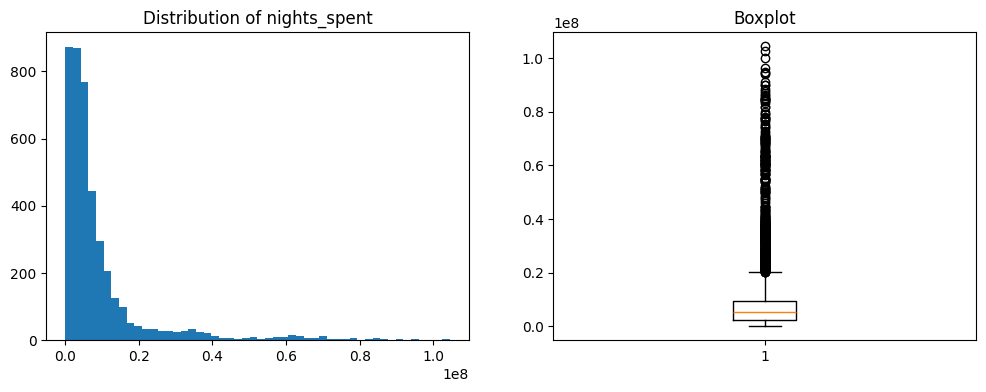

In [64]:
# Distribution of night spent
print(y.describe())

# outliers
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(y, bins=50)
plt.title('Distribution of nights_spent')
plt.subplot(1,2,2)
plt.boxplot(y)
plt.title('Boxplot')
plt.show()

# Log transformation to night spent
Our target variable exhibits variance that scales with magnitude. Standard deviation (13.3M) exceeds the mean (9.2M), indicating severe heteroscedasticity. Machine learning models assume constant variance across the prediction range—this assumption is violated.

**Consequence:** Model optimization becomes unstable. Gradient-based algorithms receive inconsistent signals depending on the scale of values, leading to poor convergence and biased predictions toward high-magnitude observations.


In [ ]:
cols_to_exclude = ["nights_spent", "geo", "year", "country"]
X = df_clean.drop(
    columns=[c for c in cols_to_exclude if c in df_clean.columns], errors="ignore"
)
y = df_clean["nights_spent"]
y_log = np.log1p(y)

N_FOLDS = 5
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
oof_predictions_log = np.zeros(len(X))
oof_predictions = np.zeros(len(X))
fold_scores = []

model_params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "tree_method": "hist",
    "learning_rate": 0.1,
    "max_depth": 11,
    "min_child_weight": 16,
    "subsample": 0.77,
    "colsample_bytree": 0.96,
    "lambda": 0.07,
    "alpha": 8.48,
    "random_state": 42,
    "verbosity": 0,
}

for fold, (train_idx, val_idx) in enumerate(cv.split(X)):
    X_train_fold = X.iloc[train_idx]
    X_val_fold = X.iloc[val_idx]
    y_train_fold = y_log.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]

    dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
    dval = xgb.DMatrix(X_val_fold, label=y_log.iloc[val_idx])

    model = xgb.train(
        params=model_params,
        dtrain=dtrain,
        num_boost_round=200,
        evals=[(dval, "validation")],
        early_stopping_rounds=20,
        verbose_eval=False,
    )

    fold_predictions_log = model.predict(dval)
    fold_predictions = np.expm1(fold_predictions_log)
    oof_predictions_log[val_idx] = fold_predictions_log
    oof_predictions[val_idx] = fold_predictions

    fold_rmse = np.sqrt(mean_squared_error(y_val_fold, fold_predictions))
    fold_r2 = r2_score(y_val_fold, fold_predictions)
    fold_scores.append({"fold": fold + 1, "rmse": fold_rmse, "r2": fold_r2})

overall_rmse = np.sqrt(mean_squared_error(y, oof_predictions))
overall_r2 = r2_score(y, oof_predictions)

overall_rmse_log = np.sqrt(mean_squared_error(y_log, oof_predictions_log))
overall_r2_log = r2_score(y_log, oof_predictions_log)

fold_rmses = [score["rmse"] for score in fold_scores]
rmse_mean = np.mean(fold_rmses)
rmse_std = np.std(fold_rmses)

imputer = SimpleImputer(strategy='median')
X[["pop", "gdp_capita"]] = imputer.fit_transform(X[["pop", "gdp_capita"]])

meta_features = np.column_stack([oof_predictions_log, X[["pop", "gdp_capita"]].values])
meta_oof_predictions_log = np.zeros(len(X))
meta_oof_predictions = np.zeros(len(X))
meta_cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=43)

for fold, (train_idx, val_idx) in enumerate(meta_cv.split(X)):
    X_meta_train = meta_features[train_idx]
    X_meta_val = meta_features[val_idx]
    y_meta_train = y_log.iloc[train_idx]
    y_meta_val = y_log.iloc[val_idx]

    meta_model = Ridge(alpha=1.0, random_state=42)
    meta_model.fit(X_meta_train, y_meta_train)

    meta_fold_predictions_log = meta_model.predict(X_meta_val)
    meta_fold_predictions = np.expm1(meta_fold_predictions_log)
    meta_oof_predictions_log[val_idx] = meta_fold_predictions_log
    meta_oof_predictions[val_idx] = meta_fold_predictions

meta_rmse = np.sqrt(mean_squared_error(y, meta_oof_predictions))
meta_r2 = r2_score(y, meta_oof_predictions)

meta_rmse_log = np.sqrt(mean_squared_error(y_log, meta_oof_predictions_log))
meta_r2_log = r2_score(y_log, meta_oof_predictions_log)

X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)
y_test_simple_original = y[y_test_simple.index]

dtrain_simple = xgb.DMatrix(X_train_simple, label=y_train_simple)
dtest_simple = xgb.DMatrix(X_test_simple, label=y_test_simple)

simple_model = xgb.train(
    params=model_params,
    dtrain=dtrain_simple,
    num_boost_round=200,
    evals=[(dtest_simple, "test")],
    early_stopping_rounds=20,
    verbose_eval=False,
)

simple_predictions_log = simple_model.predict(dtest_simple)
simple_predictions = np.expm1(simple_predictions_log)

simple_rmse = np.sqrt(mean_squared_error(y_test_simple_original, simple_predictions))
simple_r2 = r2_score(y_test_simple_original, simple_predictions)

improvement = ((overall_rmse - meta_rmse) / overall_rmse) * 100

results_df = pd.DataFrame(
    {
        "actual": y,
        "oof_predictions": oof_predictions,
        "meta_predictions": meta_oof_predictions,
        "oof_residuals": y - oof_predictions,
        "meta_residuals": y - meta_oof_predictions,
    }
)

results_df.to_csv("simple_oof_stacking_results_log.csv", index=False)

In [71]:
print("\nXGBOOST WITH CROSS-VALIDATION:")
print(f"   Overall RMSE: {overall_rmse:.2f}")
print(f"   Overall R²: {overall_r2:.4f}")
print(f"   Overall RMSE (log scale): {overall_rmse_log:.4f}")
print(f"   Overall R² (log scale): {overall_r2_log:.4f}")
print(f"   Average RMSE per fold: {rmse_mean:.2f} ± {rmse_std:.2f}")

print("\nFOLD BREAKDOWN:")
for score in fold_scores:
    print(f"   Fold {score['fold']}: RMSE={score['rmse']:.2f}, R²={score['r2']:.4f}")


print("\nMETA-MODEL (STACKING):")
print(f"   Meta RMSE: {meta_rmse:.2f}")
print(f"   Meta R²: {meta_r2:.4f}")
print(f"   Meta RMSE (log scale): {meta_rmse_log:.4f}")
print(f"   Meta R² (log scale): {meta_r2_log:.4f}")

print("\nSIMPLE MODEL (Train/Test Split):")
print(f"   Simple RMSE: {simple_rmse:.2f}")
print(f"   Simple R²: {simple_r2:.4f}")


print("\n" + "="*70)
print("=== COMPARATIVE TABLE ===")
print("="*70)
print(f"{'Model':<35} {'RMSE':<12} {'R²':<10}")
print("-"*70)
print(f"{'XGBoost (Cross-Validation)':<35} {overall_rmse:<12.2f} {overall_r2:<10.4f}")
print(f"{'Meta-Model (Stacking)':<35} {meta_rmse:<12.2f} {meta_r2:<10.4f}")
print(f"{'XGBoost Simple (Train/Test)':<35} {simple_rmse:<12.2f} {simple_r2:<10.4f}")
print("="*70)

if improvement > 0:
    print(f"\nTACKING IMPROVEMENT: +{improvement:.2f}%")
    print(f"   Meta-model reduced error by {abs(overall_rmse - meta_rmse):.2f} nights")
else:
    print(f"\nSTACKING DETERIORATION: {improvement:.2f}%")


XGBOOST WITH CROSS-VALIDATION:
   Overall RMSE: 4510334.15
   Overall R²: 0.8850
   Overall RMSE (log scale): 0.3035
   Overall R² (log scale): 0.9269
   Average RMSE per fold: 4474350.99 ± 568592.39

FOLD BREAKDOWN:
   Fold 1: RMSE=3821998.69, R²=0.9110
   Fold 2: RMSE=5288086.38, R²=0.8682
   Fold 3: RMSE=4824377.38, R²=0.8499
   Fold 4: RMSE=3847519.99, R²=0.9097
   Fold 5: RMSE=4589772.54, R²=0.8885

META-MODEL (STACKING):
   Meta RMSE: 4499457.72
   Meta R²: 0.8856
   Meta RMSE (log scale): 0.2993
   Meta R² (log scale): 0.9289

SIMPLE MODEL (Train/Test Split):
   Simple RMSE: 3910667.43
   Simple R²: 0.9068

=== COMPARATIVE TABLE ===
Model                               RMSE         R²        
----------------------------------------------------------------------
XGBoost (Cross-Validation)          4510334.15   0.8850    
Meta-Model (Stacking)               4499457.72   0.8856    
XGBoost Simple (Train/Test)         3910667.43   0.9068    

TACKING IMPROVEMENT: +0.24%
   Meta-mod

In [72]:
# Train XGBoost final
dtrain_final = xgb.DMatrix(X, label=y_log)
modelo_xgb_final = xgb.train(params=model_params, dtrain=dtrain_final, num_boost_round=200)

# train meta-modelo final
preds_log = modelo_xgb_final.predict(dtrain_final)
meta_feat = np.column_stack([preds_log, X[["pop", "gdp_capita"]].values])
modelo_meta_final = Ridge(alpha=1.0, random_state=42)
modelo_meta_final.fit(meta_feat, y_log)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,42


# Predictions

In [ ]:
query = "SELECT * FROM aklewagonproject.etrace.cleaned_final_jaume_dataset"

In [ ]:
def predict_nights_spent(query):
    df = load_from_bq(query)
    new_data_clean = df[X.columns].copy()
    new_data_clean[numeric_cols] = imputer.transform(new_data_clean[numeric_cols])

    dnew = xgb.DMatrix(new_data_clean)
    xgb_pred_log = final_xgb_model.predict(dnew)
    xgb_pred = np.expm1(xgb_pred_log)

    meta_features_new = np.column_stack([
        xgb_pred_log,
        new_data_clean[["pop", "gdp_capita"]].values
    ])
    stack_pred_log = final_meta_model.predict(meta_features_new)
    stack_pred = np.expm1(stack_pred_log)

    df['pred_xgboost'] = xgb_pred
    df['pred_stacking'] = stack_pred

    return df